<a href="https://colab.research.google.com/github/billpottle/TournamentML/blob/master/Division_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to the online division generator! To get the excel file or see more instructions, please visit the [github.](https://github.com/billpottle/TournamentML/) 

Move your mouse over the  [   ] to the left of each line, and then click the triangle to run it. 

---



# STEP 1- Upload your file. It should be named athletes.csv


In [0]:
%reset -f
from google.colab import files
uploaded = files.upload()

Saving athletes.csv to athletes.csv


# **STEP 2** -Click the next triangle to run the entire analysis. 



*  Enter the number of divisions you want in the k variable. It's usually good to have on average 3-4 people per division.  For instance 150 athletes divided by 3 per division = 50 divisions. You can also set based on how many medals you have. 

*  You will download a file called output.csv and your input data will be deleted for privacy reasons.

* Alternatively, if you would like more insight into your data or this model's code, you may click the individual steps below. 

---



In [0]:

import math
import pandas as pd
import io
from matplotlib import pyplot as plt
import numpy as np
import numpy.linalg as nla
import seaborn as sns
import altair as alt
import re
import pdb  # for Python debugger
import sys
from os.path import join


athlete_data = pd.read_csv(io.StringIO(uploaded['athletes.csv'].decode('utf-8')))

# Set the output display to have one digit for decimal places and limit it to
# printing 15 rows.
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15





# We can rename the columns.
athlete_data.columns = ['Name', 'Weight', 'School', 'Belt', 'Age', 'Gender']



# Save the original column names
original_cols = athlete_data.columns.values

# Make data numeric values
athlete_data[["Weight", "Belt", "Age", "Gender"]] = athlete_data[["Weight", "Belt", "Age", "Gender"]].apply(pd.to_numeric)

# Name and school aren't used in clustering model. 
athlete_data_toCluster = athlete_data.drop(columns =["Name", "School"])

#Define the similarity function for 2 athletes. 
def getSimilarity(obj1, obj2):
  len1 = len(obj1.index)
  len2 = len(obj2.index)
  if not (len1 == len2):
    print ("Error: Compared objects must have same number of features.")
    sys.exit()
    return 0
  else:
    similarity = obj1 - obj2
    similarity = np.sum((similarity**2.0) / 10.0)
    similarity = 1 - math.sqrt(similarity)
    return similarity
  
  
 #Model functions from Google's example. 
def dfSimilarity(df, centroids):
  ### dfSimilarity = Calculate similarities for dataframe input
  ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
  ### Implement this with matrix operations
  ### See the Appendix for further explanation
  numPoints = len(df.index)
  numCentroids = len(centroids.index)
  ## Strictly speaking, we don't need to calculate the norm of points
  # because it adds a constant bias to distances
  # But calculating it so that the similarity doesn't go negative
  # And that we expect similarities in [0,1] which aids debugging
  pointNorms = np.square(nla.norm(df, axis=1))
  pointNorms = np.reshape(pointNorms, [numPoints, 1])
  ## Calculate the norm of centroids
  centroidNorms = np.square(nla.norm(centroids, axis=1))
  centroidNorms = np.reshape(centroidNorms, (1, numCentroids))
  ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
  similarities = pointNorms + centroidNorms - 2.0 * np.dot(
      df, np.transpose(centroids))
  # Divide by the number of features
  # Which is 10 because the one-hot encoding means the "Maker" and "Bean" are
  # weighted twice
  similarities = similarities / 10.0
  # numerical artifacts lead to negligible but negative values that go to NaN on the root
  similarities = similarities.clip(min=0.0)
  # Square root since it's ||a-b||^2
  similarities = np.sqrt(similarities)
  return similarities


def initCentroids(df, k, feature_cols):
  # Pick 'k' examples are random to serve as initial centroids
  limit = len(df.index)
  centroids_key = np.random.randint(0, limit - 1, k)
  centroids = df.loc[centroids_key, feature_cols].copy(deep=True)
  # the indexes get copied over so reset them
  centroids.reset_index(drop=True, inplace=True)
  return centroids


def pt2centroid(df, centroids, feature_cols):
  ### Calculate similarities between all points and centroids
  ### And assign points to the closest centroid + save that distance
  numCentroids = len(centroids.index)
  numExamples = len(df.index)
  # dfSimilarity = Calculate similarities for dataframe input
  dist = dfSimilarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols])
  df.loc[:, 'centroid'] = np.argmin(dist, axis=1)  # closest centroid
  df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)  # minimum distance
  return df


def recomputeCentroids(df, centroids, feature_cols):
  ### For every centroid, recompute it as an average of the points
  ### assigned to it
  numCentroids = len(centroids.index)
  for cen in range(numCentroids):
    dfSubset = df.loc[df['centroid'] == cen,
                      feature_cols]  # all points for centroid
    if not (dfSubset.empty):  # if there are points assigned to the centroid
      clusterAvg = np.sum(dfSubset) / len(dfSubset.index)
      centroids.loc[cen] = clusterAvg
  return centroids


def kmeans(df, k, feature_cols, verbose):
  flagConvergence = False
  maxIter = 100
  iter = 0  # ensure kmeans doesn't run for ever
  centroids = initCentroids(df, k, feature_cols)
  while not (flagConvergence):
    iter += 1
    #Save old mapping of points to centroids
    oldMapping = df['centroid'].copy(deep=True)
    # Perform k-means
    df = pt2centroid(df, centroids, feature_cols)
    centroids = recomputeCentroids(df, centroids, feature_cols)
    # Check convergence by comparing [oldMapping, newMapping]
    newMapping = df['centroid']
    flagConvergence = all(oldMapping == newMapping)
    if verbose == 1:
      print('Total distance:' + str(np.sum(df['pt2centroid'])))
    if (iter > maxIter):
      print('k-means did not converge! Reached maximum iteration limit of ' \
            + str(maxIter) + '.')
      sys.exit()
      return
  print('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
  return [df, centroids]


k = 40  #@param

feature_cols = athlete_data_toCluster.columns.values  # save original columns
# initialize every point to an impossible value, the k+1 cluster
athlete_data_toCluster['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
athlete_data_toCluster['pt2centroid'] = 2
[athlete_data_toCluster, centroids] = kmeans(athlete_data_toCluster, k, feature_cols, 1)
print("Data for the first few athletess, with 'centroid' and 'pt2centroid' on"
      ' the extreme right:')
athlete_data_toCluster


#Add columns back in
athlete_data_toCluster['Name'] = athlete_data["Name"]
athlete_data_toCluster['School'] = athlete_data["School"]

#download file
from google.colab import files
athlete_data_toCluster.to_csv('output.csv') 
files.download('output.csv')

#remove original upload
!rm athletes.csv
!rm output.csv


Total distance:94.52809874086208
Total distance:83.36932632670354
Total distance:71.56539976991937
Total distance:67.13750503654074
Total distance:66.0093716679468
Total distance:63.65934664701219
Total distance:61.616377628648884
Total distance:58.327921799535616
Total distance:59.42939308158201
k-means converged for 40 clusters after 9 iterations!
Data for the first few athletess, with 'centroid' and 'pt2centroid' on the extreme right:


OPTIONAL - Step 2 above will give you the final result you need. However, the following step by step instructions will help you learn more about your particular data and how the model works. Make sure to click on the individual cells in order. 

In [0]:
#@title Load data and perform initial cleaning

import math

from matplotlib import pyplot as plt
import numpy as np
import numpy.linalg as nla
import pandas as pd
import seaborn as sns
import altair as alt
import re
import pdb  # for Python debugger
import sys
from os.path import join

# Set the output display to have one digit for decimal places and limit it to
# printing 15 rows.
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15


# We can rename the columns.
athlete_data.columns = ['Name', 'Weight', 'School', 'Belt', 'Age', 'Gender']


# Save the original column names
original_cols = athlete_data.columns.values

#Make the data have values that are numbers, not strings. 
athlete_data[["Weight", "Belt", "Age", "Gender"]] = athlete_data[["Weight", "Belt", "Age", "Gender"]].apply(pd.to_numeric)

#Create a new dataframe that doesn't use Name or School to determine matchups. 
athlete_data_toCluster = athlete_data.drop(columns =["Name", "School"])

print("First few rows of your data")
athlete_data.head()



NameError: ignored

Check the distribution of values in your data (Optional). Remove the # before any one line of code to plot that value. 

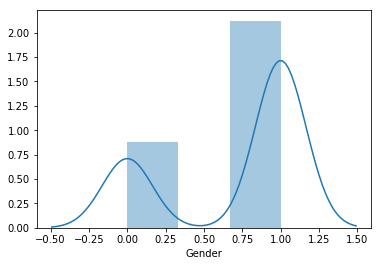

In [0]:

sns.distplot(athlete_data['Age'])
#sns.distplot(athlete_data['Gender'])
#sns.distplot(athlete_data['Weight'])
#sns.distplot(athlete_data['Belt'])


Imagine that each athlete is a coordinate in 4 dimensional space, where the axes are weight, belt, gender, and age. This function simply finds the difference between any two points. 

In [0]:
def getSimilarity(obj1, obj2):
  len1 = len(obj1.index)
  len2 = len(obj2.index)
  if not (len1 == len2):
    print ("Error: Compared objects must have same number of features.")
    sys.exit()
    return 0
  else:
    similarity = obj1 - obj2
    similarity = np.sum((similarity**2.0) / 10.0)
    similarity = 1 - math.sqrt(similarity)
    return similarity

To check if this model gives distances you think are correct, try entering any two athlete ids (the row number in the athletes.csv file) to see the calculated difference between them. 

In [0]:
athlete1 = 157  #@param
athlete2 = 160 #@param


temp = getSimilarity(athlete_data_toCluster.loc[athlete1], athlete_data_toCluster.loc[athlete2])
print("Difference =", temp, ".................", athlete_data_toCluster.loc[athlete1], ".................", athlete_data_toCluster.loc[athlete2])  


Difference = -0.70293863659264 ................. Weight   44.00
Belt      0.00
Age       5.00
Gender    1.00
Name: 157, dtype: float64 ................. Weight   49.00
Belt      0.00
Age       7.00
Gender    1.00
Name: 160, dtype: float64


Run this cell to set up the key functions for the k-means algorithm. 

In [0]:
# Code taken from Google Colab tutorial on clustering
# https://developers.google.com/machine-learning/clustering/
def dfSimilarity(df, centroids):
  ### dfSimilarity = Calculate similarities for dataframe input
  ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
  ### Implement this with matrix operations
  ### See the Appendix for further explanation
  numPoints = len(df.index)
  numCentroids = len(centroids.index)
  ## Strictly speaking, we don't need to calculate the norm of points
  # because it adds a constant bias to distances
  # But calculating it so that the similarity doesn't go negative
  # And that we expect similarities in [0,1] which aids debugging
  pointNorms = np.square(nla.norm(df, axis=1))
  pointNorms = np.reshape(pointNorms, [numPoints, 1])
  ## Calculate the norm of centroids
  centroidNorms = np.square(nla.norm(centroids, axis=1))
  centroidNorms = np.reshape(centroidNorms, (1, numCentroids))
  ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
  similarities = pointNorms + centroidNorms - 2.0 * np.dot(
      df, np.transpose(centroids))
  # Divide by the number of features
  # Which is 10 because the one-hot encoding means the "Maker" and "Bean" are
  # weighted twice
  similarities = similarities / 10.0
  # numerical artifacts lead to negligible but negative values that go to NaN on the root
  similarities = similarities.clip(min=0.0)
  # Square root since it's ||a-b||^2
  similarities = np.sqrt(similarities)
  return similarities


def initCentroids(df, k, feature_cols):
  # Pick 'k' examples are random to serve as initial centroids
  limit = len(df.index)
  centroids_key = np.random.randint(0, limit - 1, k)
  centroids = df.loc[centroids_key, feature_cols].copy(deep=True)
  # the indexes get copied over so reset them
  centroids.reset_index(drop=True, inplace=True)
  return centroids


def pt2centroid(df, centroids, feature_cols):
  ### Calculate similarities between all points and centroids
  ### And assign points to the closest centroid + save that distance
  numCentroids = len(centroids.index)
  numExamples = len(df.index)
  # dfSimilarity = Calculate similarities for dataframe input
  dist = dfSimilarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols])
  df.loc[:, 'centroid'] = np.argmin(dist, axis=1)  # closest centroid
  df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)  # minimum distance
  return df


def recomputeCentroids(df, centroids, feature_cols):
  ### For every centroid, recompute it as an average of the points
  ### assigned to it
  numCentroids = len(centroids.index)
  for cen in range(numCentroids):
    dfSubset = df.loc[df['centroid'] == cen,
                      feature_cols]  # all points for centroid
    if not (dfSubset.empty):  # if there are points assigned to the centroid
      clusterAvg = np.sum(dfSubset) / len(dfSubset.index)
      centroids.loc[cen] = clusterAvg
  return centroids


def kmeans(df, k, feature_cols, verbose):
  flagConvergence = False
  maxIter = 100
  iter = 0  # ensure kmeans doesn't run for ever
  centroids = initCentroids(df, k, feature_cols)
  while not (flagConvergence):
    iter += 1
    #Save old mapping of points to centroids
    oldMapping = df['centroid'].copy(deep=True)
    # Perform k-means
    df = pt2centroid(df, centroids, feature_cols)
    centroids = recomputeCentroids(df, centroids, feature_cols)
    # Check convergence by comparing [oldMapping, newMapping]
    newMapping = df['centroid']
    flagConvergence = all(oldMapping == newMapping)
    if verbose == 1:
      print('Total distance:' + str(np.sum(df['pt2centroid'])))
    if (iter > maxIter):
      print('k-means did not converge! Reached maximum iteration limit of ' \
            + str(maxIter) + '.')
      sys.exit()
      return
  print('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
  return [df, centroids]

Enter the number of divisions as the K variable and run the clustering algorithm. The algorithm will try to find the smallest total distance. The centroid is the group (division number) and the pt2centroid is the distance from it. 

In [0]:
k = 50  #@param

feature_cols = athlete_data_toCluster.columns.values  # save original columns
# initialize every point to an impossible value, the k+1 cluster
athlete_data_toCluster['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
athlete_data_toCluster['pt2centroid'] = 2
[athlete_data_toCluster, centroids] = kmeans(athlete_data_toCluster, k, feature_cols, 1)
print("Data for the first few athletess, with 'centroid' and 'pt2centroid' on"
      ' the extreme right:')
athlete_data_toCluster.head()

Total distance:239.65585055254854
Total distance:217.54045645342688
Total distance:206.13268966590297
Total distance:200.70875299464598
k-means converged for 50 clusters after 4 iterations!
Data for the first few athletess, with 'centroid' and 'pt2centroid' on the extreme right:


,Weight,Belt,Age,Gender,centroid,pt2centroid
0,150.00,20,15,0,2,2.64
1,127.00,20,18,0,15,0.61
2,155.00,20,15,0,2,1.41
3,90.00,20,14,0,11,1.05
4,142.00,20,16,0,10,0.56
5,140.00,20,17,0,10,0.63
6,114.00,20,39,0,27,3.65
...,...,...,...,...,...,...
157,44.00,0,5,1,6,0.71
158,40.00,0,6,1,6,0.60


Final cleanup - add back in the Name and School columns, download the output.csv file, and delete the athletes.csv. 

In [0]:
athlete_data_toCluster['Name'] = athlete_data["Name"]
athlete_data_toCluster['School'] = athlete_data["School"]

from google.colab import files
athlete_data_toCluster.to_csv('output.csv') 
files.download('output.csv')
!rm athletes.csv
!rm output.csv

NameError: ignored